In [65]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%pylab inline
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### multiple dwelling registration

You can find Multiple Dwelling Registration data including OwnerTypes and Site Manager information from the attached file. Followings are the description of columns:
* Owner: There is only 0. All BBLs of this data is living without owner in their buildings
* Ownership: Types of specific owners
    * Corp: Corporation (each unit is owned by individual owner)
    * Ind: Individual Owner
    * Off: Owned by company
    * Joint: Shared Owner (multiple owners)
    * Agent: Yes or No of representative agent of the building
    * SiteManager: Yes or No of site manager (super)
There are some NaN in "Agent" and "SiteManager" columns. 

You can replace those as 0 or drop. The results (before dropping and after dropping) were not that different. 

In [66]:
dwell = pd.read_csv('../data_processed/Multiple_Dwelling_Registration_OwnerType_Boiler_Joined.csv')
dwell = dwell.drop('Unnamed: 0',axis=1)
dwell.head()

,BBL,Owner,Ownership,Agent,SiteManager,boiler,boiler_age
0,4086640052,0,Ind,0.0,1.0,0,27.174765
1,4057400139,0,Corp,1.0,1.0,0,27.174765
2,3034570006,0,Corp,1.0,1.0,0,27.174765
3,1021160061,0,Corp,1.0,1.0,0,27.174765
4,1004360020,0,Corp,1.0,1.0,0,27.174765


In [99]:
dwell.boiler.unique()

array([0, 1, 2])

In [67]:
len(dwell)

147075

In [68]:
dwell = dwell.dropna()
dwell = dwell.drop('Owner',axis=1)

In [69]:
len(dwell)

144838

In [70]:
dwell.Ownership.unique()

array(['Ind', 'Corp', 'Off', 'Joint'], dtype=object)

In [71]:
dwell['Ownership'] = dwell['Ownership'].replace('Ind',0)
dwell['Ownership'] = dwell['Ownership'].replace('Corp',1)
dwell['Ownership'] = dwell['Ownership'].replace('Off',2)
dwell['Ownership'] = dwell['Ownership'].replace('Joint',3)

### pluto

mapPLUTO
* AssessSqft
* UnitsRes
* ResArea
* ResArea_perunit
* Res_r
* NumFloors
* Bldg_nrr
* Bldg_age
* BsmtCode
* ProxCode
* BldgClass_dummy

In [72]:
pluto = pd.read_csv('../data_processed/pluto_16')
pluto = pluto.drop('Unnamed: 0',axis=1)
pluto.head()

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.0,NaN,437 PURDY AVENUE,R3-1,NaN,7,15120.0,23400.0,5.007470e+09,1488,...,0,1960,NaN,10314,R3-1,NaN,NaN,NaN,20d,"POLYGON ((944681.4200000018 161477.381400004, ..."
1,0.0,NaN,CUNARD AVENUE,R3A/HS,NaN,4,21518.0,21518.0,5.006230e+09,0,...,0,0,NaN,10304,R3A,NaN,NaN,NaN,21d,"POLYGON ((959872.0577999949 162992.5866000056,..."
2,0.0,NaN,121 MOUNTAINVIEW AVENUE,R3-1,NaN,7,13561.0,22602.0,5.007130e+09,1316,...,0,1920,NaN,10314,R3-1,NaN,NaN,NaN,21b,"POLYGON ((949278.1987999976 161346.9971999973,..."
3,0.0,NaN,26 FANNING STREET,R3X,NaN,7,9720.0,28740.0,5.007140e+09,2188,...,0,1975,NaN,10314,R3X,NaN,NaN,NaN,21b,"POLYGON ((950061.0491999984 160815.3023999929,..."
4,0.0,NaN,335 SIMONSON AVENUE,R3A,NaN,7,7617.0,22118.0,5.011840e+09,2392,...,0,1965,NaN,10303,R3A,NaN,NaN,NaN,20c,"POLYGON ((941981.4906000048 168120.2173999995,..."


#### remove outliers

In [73]:
pluto = pluto[pluto['YearBuilt']>1750]
pluto = pluto[pluto['AssessLand']> 0]
pluto = pluto[pluto['NumBldgs'] > 0]
pluto = pluto[pluto['NumFloors'] > 0]
pluto = pluto[pluto['ResArea'] > 0]
pluto = pluto[pluto['UnitsRes'] < 8000]
pluto = pluto[pluto['UnitsRes'] > 0]
pluto = pluto[pluto['BldgFront'] > 0]

#### adjust features

In [74]:
pluto['AssessSqft'] = pluto['AssessTot']/pluto['BldgArea']
pluto = pluto[pluto['AssessSqft'] > 0]

pluto['BldgAge'] = 2017-pluto['YearBuilt']
pluto = pluto.drop('YearBuilt',axis=1)

pluto['Bldg_nrr'] = pluto['BldgDepth']/pluto['BldgFront'].astype(float)

#proxcode
#0 = unknown, 1 = detatched, 2 = attached or semi=attached
pluto['ProxCode'] = pluto['ProxCode'].replace(3, 2)

#bsmtcode
#0 = no basement, 1 = full or partial basement, 5 = unknown
pluto['BsmtCode'] = pluto['BsmtCode'].replace(2, 1)
pluto['BsmtCode'] = pluto['BsmtCode'].replace(3, 1)
pluto['BsmtCode'] = pluto['BsmtCode'].replace(4, 1)
pluto['Res_r'] = pluto['ResArea']/pluto['BldgArea'].astype(float)
pluto['ResArea_perunit'] = pluto['ResArea']/pluto['UnitsRes'].astype(float)

bldgclass = []
for elem in pluto['BldgClass']:
    bldgclass.append(str(elem[0]))
bldgclasscat = []
for elem in bldgclass:
    if elem == 'A':
        bldgclasscat.append(1)
    elif elem == 'B':
        bldgclasscat.append(2)
    elif elem == 'C':
        bldgclasscat.append(3)
    elif elem == 'S':
        bldgclasscat.append(3)
    elif elem == 'D':
        bldgclasscat.append(4)
    elif elem == 'O8':
        bldgclasscat.append(4)
    elif elem == 'R':
        bldgclasscat.append(4)
    elif elem == 'L':
        bldgclasscat.append(4) 
    else:
        bldgclasscat.append(0)
pluto['BldgClass_dummy'] = bldgclasscat

proxcode = []
for elem in pluto['ProxCode']:
    proxcode.append(elem)
proxcodecat = []
for elem in proxcode:
    if elem == 0:
        proxcodecat.append('pc0')
    elif elem == 1:
        proxcodecat.append('pc1')
    elif elem == 2:
        proxcodecat.append('pc2')
pluto['ProxCode_dummy'] = proxcodecat

bsmtcode = []
for elem in pluto['BsmtCode']:
    bsmtcode.append(elem)
bsmtcodecat = []
for elem in bsmtcode:
    if elem == 0:
        bsmtcodecat.append('bsmt0')
    elif elem == 1:
        bsmtcodecat.append('bsmt1')
    elif elem == 5:
        bsmtcodecat.append('bsmt5')
pluto['BsmtCode_dummy'] = bsmtcodecat

BldgClass
 1: A (one family housing)
 2: B (two family housing)
 3: C + S (walk up + mixed use)
 4: D + O8 (elevator apartment + apt with office)
 5: R (condominium)
 6: L (loft)
 0: Others

In [75]:
pluto.head(2)

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,ZoneDist3,ZoneDist4,ZoneMap,geometry,AssessSqft,BldgAge,Bldg_nrr,Res_r,ResArea_perunit,BldgClass_dummy
0,0.0,NaN,437 PURDY AVENUE,R3-1,NaN,7,15120.0,23400.0,5.007470e+09,1488,...,NaN,NaN,20d,"POLYGON ((944681.4200000018 161477.381400004, ...",15.725806,57,2.583333,1.0,744.0,2
2,0.0,NaN,121 MOUNTAINVIEW AVENUE,R3-1,NaN,7,13561.0,22602.0,5.007130e+09,1316,...,NaN,NaN,21b,"POLYGON ((949278.1987999976 161346.9971999973,...",17.174772,97,1.588235,1.0,1316.0,1


In [76]:
pluto.columns

Index([u'APPBBL', u'APPDate', u'Address', u'AllZoning1', u'AllZoning2',
       u'AreaSource', u'AssessLand', u'AssessTot', u'BBL', u'BldgArea',
       u'BldgClass', u'BldgDepth', u'BldgFront', u'Block', u'BoroCode',
       u'Borough', u'BsmtCode', u'BuiltCode', u'BuiltFAR', u'CB2010', u'CD',
       u'CT2010', u'ComArea', u'CommFAR', u'CondoNo', u'Council', u'EDesigNum',
       u'Easements', u'ExemptLand', u'ExemptTot', u'Ext', u'FacilFAR',
       u'FactryArea', u'FireComp', u'GarageArea', u'HealthArea', u'HistDist',
       u'IrrLotCode', u'LandUse', u'Landmark', u'Lot', u'LotArea', u'LotDepth',
       u'LotFront', u'LotType', u'LtdHeight', u'MAPPLUTO_F', u'NumBldgs',
       u'NumFloors', u'OfficeArea', u'OtherArea', u'Overlay1', u'Overlay2',
       u'OwnerName', u'OwnerType', u'PLUTOMapID', u'PolicePrct', u'ProxCode',
       u'ResArea', u'ResidFAR', u'RetailArea', u'SHAPE_Area', u'SHAPE_Leng',
       u'SPDist1', u'SPDist2', u'Sanborn', u'SchoolDist', u'SplitZone',
       u'StrgeArea', 

#### drop irrelevant features

In [77]:
pluto = pluto[['BBL', 'AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', \
               'NumFloors', 'Bldg_nrr', 'BldgAge', 'BsmtCode', 'ProxCode', 'BldgClass_dummy']]

### import violations

In [78]:
vios = pd.read_csv('../data_processed/VIOLATION_HEATHOTWATER_by_bbl_season.csv')
vios = vios.drop('Unnamed: 0',axis=1)

In [79]:
vios.head()

,BBL,Sum_season_vio,Avg_season_vio
0,1000160100,2,0.50
1,1000167509,1,0.25
2,1000170029,1,0.25
3,1000297501,1,0.25
4,1000530006,12,3.00


### view datasets

In [80]:
pluto.head()

,BBL,AssessSqft,UnitsRes,ResArea_perunit,Res_r,NumFloors,Bldg_nrr,BldgAge,BsmtCode,ProxCode,BldgClass_dummy
0,5.007470e+09,15.725806,2,744.0,1.0,1.0,2.583333,57,1.0,1.0,2
2,5.007130e+09,17.174772,1,1316.0,1.0,2.5,1.588235,97,1.0,1.0,1
3,5.007140e+09,13.135283,2,1094.0,1.0,2.0,1.923077,42,0.0,1.0,2
4,5.011840e+09,9.246656,1,2392.0,1.0,2.0,1.769231,52,0.0,1.0,1
5,5.007650e+09,17.458111,1,1122.0,1.0,2.5,1.764706,92,1.0,1.0,1


In [81]:
pluto = pluto.reset_index()
pluto = pluto.drop('index',axis=1)

In [82]:
dwell.head()

,BBL,Ownership,Agent,SiteManager,boiler,boiler_age
0,4086640052,0,0.0,1.0,0,27.174765
1,4057400139,1,1.0,1.0,0,27.174765
2,3034570006,1,1.0,1.0,0,27.174765
3,1021160061,1,1.0,1.0,0,27.174765
4,1004360020,1,1.0,1.0,0,27.174765


In [83]:
vios.head()

,BBL,Sum_season_vio,Avg_season_vio
0,1000160100,2,0.50
1,1000167509,1,0.25
2,1000170029,1,0.25
3,1000297501,1,0.25
4,1000530006,12,3.00


In [84]:
print dwell.BBL.dtypes
print vios.BBL.dtypes
print pluto.BBL.dtypes

int64
int64
float64


In [85]:
print len(dwell)
print len(vios)
print len(pluto)

144838
17472
753540


### merge on BBL

In [86]:
pluto['BBL'] = pluto['BBL'].astype(int)

In [87]:
print dwell.BBL.dtypes
print vios.BBL.dtypes
print pluto.BBL.dtypes

int64
int64
int64


In [88]:
vios_dwell = pd.merge(vios, dwell, on='BBL', how='right')

In [89]:
vios_dwell.isnull().sum()

BBL                    0
Sum_season_vio    130185
Avg_season_vio    130185
Ownership              0
Agent                  0
SiteManager            0
boiler                 0
boiler_age             0
dtype: int64

In [90]:
vios_dwell = vios_dwell.replace(np.nan, 0)

In [91]:
dvp = pd.merge(pluto, vios_dwell, on='BBL', how='right')

In [92]:
dvp.isnull().sum()

BBL                   0
AssessSqft         5976
UnitsRes           5976
ResArea_perunit    5976
Res_r              5976
NumFloors          5976
Bldg_nrr           5976
BldgAge            5976
BsmtCode           5976
ProxCode           5976
BldgClass_dummy    5976
Sum_season_vio        0
Avg_season_vio        0
Ownership             0
Agent                 0
SiteManager           0
boiler                0
boiler_age            0
dtype: int64

In [93]:
dvp  = pvd.dropna()

In [94]:
len(pvd)

138862

In [95]:
dvp['vio_binary'] = [1 if x > 0 else 0 for x in dvp['Avg_season_vio']]

#### descriptive analysis

In [96]:
dvp.describe()

,BBL,AssessSqft,UnitsRes,ResArea,ResArea_perunit,Res_r,NumFloors,Bldg_nrr,BldgAge,BsmtCode,ProxCode,BldgClass_dummy,Sum_season_vio,Avg_season_vio,Ownership,Agent,SiteManager,boiler,boiler_age,vio_binary
count,1.388620e+05,138862.000000,138862.000000,1.388620e+05,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.00000,138862.000000,138862.000000,138862.000000
mean,2.782979e+09,24.915142,14.520711,1.365001e+04,986.590534,0.950295,3.673191,2.424622,85.507259,2.565475,1.074873,3.001361,0.362468,0.090617,0.962805,0.756002,0.80315,0.012610,27.180528,0.103340
std,1.034708e+09,31.273412,45.622941,4.724897e+04,1060.044417,0.126208,2.623617,1.535914,30.144591,1.998596,0.940011,0.550689,1.789059,0.447265,0.962415,0.429493,0.39762,0.134845,8.989871,0.304404
min,1.000070e+09,0.315600,1.000000,1.070000e+02,26.000000,0.009232,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.000000,0.000000
25%,2.037130e+09,9.665155,3.000000,2.964000e+03,745.000000,1.000000,2.500000,1.900000,86.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,27.174765,0.000000
50%,3.023030e+09,14.950067,4.000000,3.808000e+03,900.000000,1.000000,3.000000,2.444444,92.000000,1.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.000000,1.00000,0.000000,27.174765,0.000000
75%,3.071688e+09,26.052529,9.000000,7.358000e+03,1120.000000,1.000000,4.000000,3.000000,107.000000,5.000000,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000,1.00000,0.000000,27.174765,0.000000
max,5.080500e+09,3775.858779,5860.000000,6.698000e+06,330434.000000,15.071305,76.000000,331.823529,219.000000,5.000000,2.000000,4.000000,81.000000,20.250000,3.000000,1.000000,1.00000,2.000000,2012.000000,1.000000


#### continuous var relationship with dep

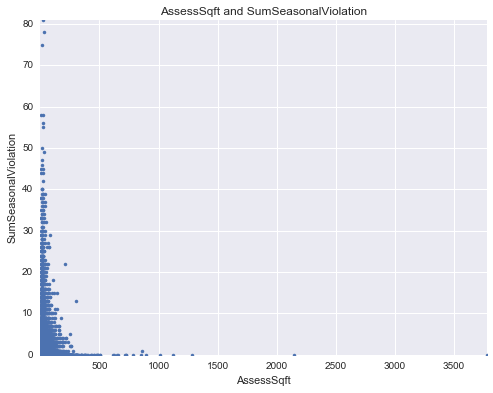

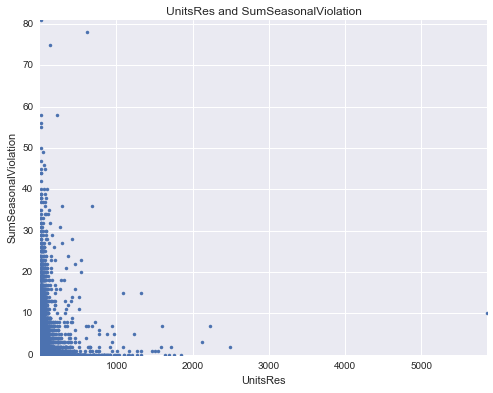

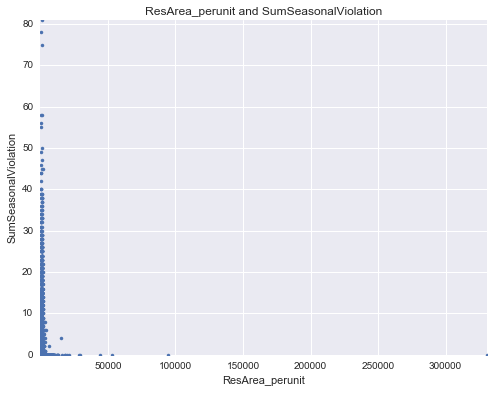

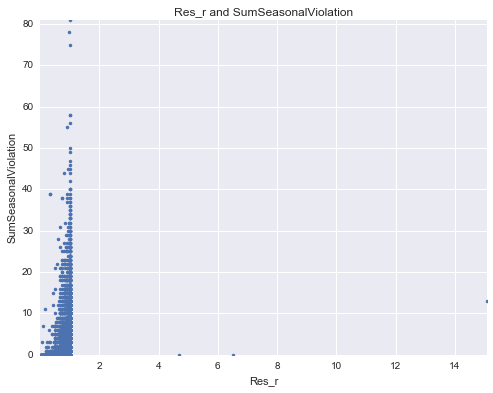

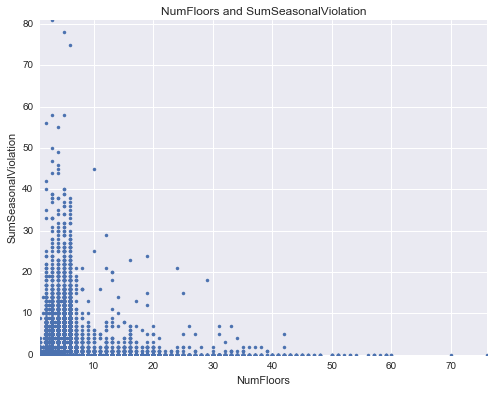

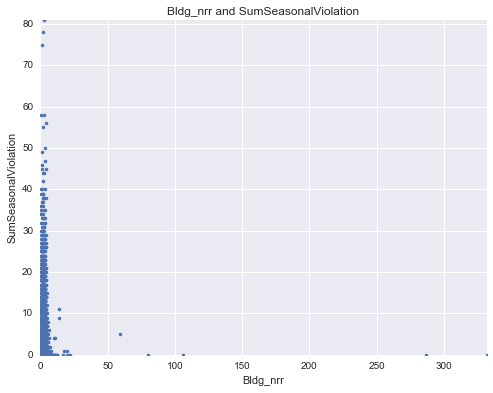

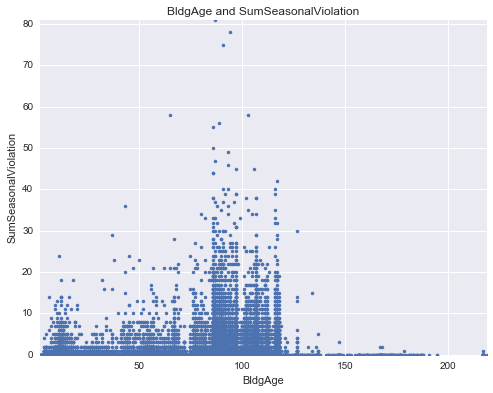

In [97]:
cols = ['AssessSqft','UnitsRes', 'ResArea_perunit','Res_r','NumFloors','Bldg_nrr',\
       'BldgAge']
for elem in cols:
    plt.figure(figsize=(8,6))
    plt.plot(dvp[elem],dvp['Sum_season_vio'], '.')
    plt.title(elem + ' and SumSeasonalViolation')
    plt.xlabel(elem)
    plt.ylabel('SumSeasonalViolation')
    plt.xlim(min(dvp[elem]),max(dvp[elem]))
    plt.ylim(min(dvp['Sum_season_vio']),max(dvp['Sum_season_vio']))

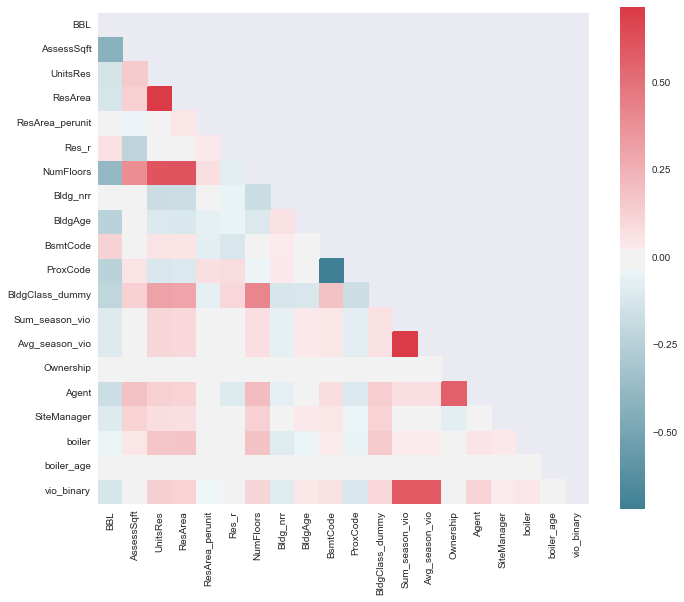

In [98]:
corr = dvp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, ax=ax)


#### logistic regression

In [100]:
print len(dvp[dvp['vio_binary']==0])/float(len(dvp))
print len(dvp[dvp['vio_binary']==1])/float(len(dvp))

0.896659993375
0.103340006625


In [93]:
dvp.columns

Index([u'BBL', u'AssessSqft', u'UnitsRes', u'ResArea', u'ResArea_perunit',
       u'Res_r', u'NumFloors', u'Bldg_nrr', u'BldgAge', u'BsmtCode',
       u'ProxCode', u'BldgClass_dummy', u'Ownership', u'Agent', u'SiteManager',
       u'boiler', u'boiler_age', u'Sum_season_vio', u'Avg_season_vio',
       u'vio_binary'],
      dtype='object')

The percentage of correctly classified datapoints, or accuracy, can be calculated with the following formula: ACC = (TP + TN) / (TP + TN + FP + FN). The percentage of incorrectly classified datapoints over the test set can be calculated with the following formula: (FP + FN) / (TP + TN + FP + FN), or 1 - ACC.

In [101]:
X = dvp.loc[:,['AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', 'NumFloors', 'Bldg_nrr', 'BldgAge', \
               'BsmtCode', 'ProxCode', 'BldgClass_dummy', 'Ownership', 'Agent', 'SiteManager', 'boiler', 'boiler_age']]
y = dvp.loc[:,['vio_binary']]
is_rsquared = []
os_acc = []
os_inacc = []
TN = []
FN = []
TP = []
FP = []
for i in np.arange(1,300,20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    mod = smf.Logit(y_train, X_train)
    res = mod.fit()
    is_rsquared.append(res.prsquared)
    y_pred = res.predict(X_test)
    results = pd.concat([y_test,y_pred],axis=1)
    results = results.rename(columns={0:'y_pred'})
    results['vio_pred'] = [1 if x >= 0.5 else 0 for x in y_pred]
    confusion = confusion_matrix(results['vio_binary'], results['vio_pred'])
    TN.append(confusion[0][0])
    FN.append(confusion[1][0])
    TP.append(confusion[1][1])
    FP.append(confusion[0][1])
    os_acc.append((confusion[1][1]+confusion[0][0])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
    os_inacc.append((confusion[1][0]+confusion[0][0])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
print 'Average in sample psuedo rsquared: '+str(np.mean(is_rsquared))
print 'Average percentage of correctly classified out of sample data points: '+str(np.mean(os_acc))
print 'Average percentage of incorrectly classified out of sample data points: '+str(np.mean(os_inacc))
#print 'Mean true negative: '+str(np.mean(TN))
#print 'Mean false negative: '+str(np.mean(FN))
#print 'Mean true positive: '+str(np.mean(TP))
#print 'Mean false positive: '+str(np.mean(FP))

Optimization terminated successfully.
         Current function value: 0.303616
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.304981
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.303768
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.303313
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.304803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.303247
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.305010
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.301122
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.304405
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.302997
  

//anaconda/lib/python2.7/site-packages/statsmodels-0.8.0-py2.7-macosx-10.6-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.304283
         Iterations 7
Average in sample psuedo rsquared: 0.0859387995101
Average percentage of correctly classified out of sample data points: 0.895960720131
Average percentage of incorrectly classified out of sample data points: 0.997513729769


#### try logistic regression with undersampling the majority class

In [136]:
is_rsquared = []
os_acc = []
os_inacc = []
TN = []
FN = []
TP = []
FP = []
odds = []
pvalues = []
for i in np.arange(1,300,20):
    zeros = dvp[dvp['vio_binary']==0]
    sample_zeros = zeros.sample(n=len(dvp[dvp['vio_binary']==1]))
    newdf = pd.concat([dvp[dvp['vio_binary']==1], sample_zeros])
    X = newdf.loc[:,['AssessSqft', 'UnitsRes', 'ResArea_perunit',
           'Res_r', 'NumFloors', 'Bldg_nrr', 'BldgAge', 'BsmtCode',
           'ProxCode', 'BldgClass_dummy', 'Ownership', 'Agent', 'SiteManager', 'boiler', 'boiler_age']]
    y = newdf.loc[:,['vio_binary']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    mod = smf.Logit(y_train, X_train)
    res = mod.fit()
    odds.append(np.exp(res.params))
    pvalues.append(res.pvalues)
    is_rsquared.append(res.prsquared)
    y_pred = res.predict(X_test)
    results = pd.concat([y_test,y_pred],axis=1)
    results = results.rename(columns={0:'y_pred'})
    results['vio_pred'] = [1 if x >= 0.5 else 0 for x in y_pred]
    confusion = confusion_matrix(results['vio_binary'], results['vio_pred'])
    TN.append(confusion[0][0])
    FN.append(confusion[1][0])
    TP.append(confusion[1][1])
    FP.append(confusion[0][1])
    os_acc.append((confusion[1][1]+confusion[0][0])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
    os_inacc.append((confusion[1][0]+confusion[0][0])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
print 'Average in sample psuedo rsquared: '+str(np.mean(is_rsquared))
print 'Average percentage of correctly classified out of sample data points: '+str(np.mean(os_acc))
print 'Average percentage of incorrectly classified out of sample data points: '+str(np.mean(os_inacc))
pvaluedf = pd.concat([elem for elem in pvalues],axis=1)
pvaluedf['avg_pvalue'] = pvaluedf.mean(axis=1)
pvaluedf = pvaluedf.reset_index()
pvaluedf = pvaluedf[['index','avg_pvalue']]
pvaluedf = pvaluedf.rename(columns={'index':'variable_name'})
pvaluedf['avg_pvalue'] = pvaluedf['avg_pvalue'].map('{:,.2f}'.format)

oddsdf = pd.concat([elem for elem in odds],axis=1)
oddsdf['avg_oddsratio'] = oddsdf.mean(axis=1)
oddsdf = oddsdf.reset_index()
oddsdf = oddsdf[['index','avg_oddsratio']]
oddsdf = oddsdf.rename(columns={'index':'variable_name'})
oddsdf['avg_oddsratio'] = oddsdf['avg_oddsratio'].map('{:,.2f}'.format)

Optimization terminated successfully.
         Current function value: 0.611668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.612571
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.606031
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.613905
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.611192
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.612836
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.610371
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.608542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.612224
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.605478
  

In [138]:
pvaluedf

,variable_name,avg_pvalue
0,AssessSqft,0.00
1,UnitsRes,0.00
2,ResArea_perunit,0.00
3,Res_r,0.26
4,NumFloors,0.00
5,Bldg_nrr,0.00
6,BldgAge,0.00
7,BsmtCode,0.01
8,ProxCode,0.00
9,BldgClass_dummy,0.14


In [137]:
oddsdf

,variable_name,avg_oddsratio
0,AssessSqft,0.99
1,UnitsRes,1.01
2,ResArea_perunit,1.00
3,Res_r,1.15
4,NumFloors,1.12
5,Bldg_nrr,0.79
6,BldgAge,1.01
7,BsmtCode,0.97
8,ProxCode,0.76
9,BldgClass_dummy,0.94


#### try logistic with oversampling minority class

In [139]:
X = dvp.loc[:,['AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', 'NumFloors', 'Bldg_nrr', 'BldgAge', \
                 'BsmtCode', 'ProxCode', 'BldgClass_dummy', 'Ownership', 'Agent', 'SiteManager']]
y = dvp.loc[:,['vio_binary']]
is_rsquared = []
os_acc = []
os_inacc = []
TN = []
FN = []
TP = []
FP = []
for i in np.arange(1,300,20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    X_train_1, X_vali, y_train_1, y_vali = train_test_split(X_train, y_train, test_size=0.33, random_state=i)
    sm = SMOTE(random_state=i, ratio = 1.0)
    #re-read this
    X_train_res, y_train_res = sm.fit_sample(X_train_1, y_train_1)
    mod = smf.Logit(y_train_res, X_train_res)
    res = mod.fit()
    is_rsquared.append(res.prsquared)
    #predict test, not validation
    y_pred = res.predict(X_vali)
    results = pd.concat([y_vali,y_pred],axis=1)
    results = results.rename(columns={0:'y_pred'})
    results['vio_pred'] = [1 if x >= 0.5 else 0 for x in y_pred]
    confusion = confusion_matrix(results['vio_binary'], results['vio_pred'])
    TN.append(confusion[0][0])
    FN.append(confusion[1][0])
    TP.append(confusion[1][1])
    FP.append(confusion[0][1])
    os_acc.append((confusion[1][1]+confusion[0][0])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
    os_inacc.append((confusion[1][0]+confusion[0][0])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
print 'Average in sample psuedo rsquared: '+str(np.mean(is_rsquared))
print 'Average percentage of correctly classified out of sample data points: '+str(np.mean(os_acc))
print 'Average percentage of incorrectly classified out of sample data points: '+str(np.mean(os_inacc))

/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimization terminated successfully.
         Current function value: 0.603184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.604782
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.606717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.602608
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.606125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.604253
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.605318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.606786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.606813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.602855
  